In this part, we'll try to plot the time-course of 1 IC extracted from the EEG of 1 subject on 1 trial.

# First let's extract the time scale data and the time-course data from the .mat file:

In [1]:
import h5py
import numpy as np
# import xarray as xr
# from utilities import flatten_dict

In [2]:
path = "E:/timot/Documents/1 - Centrale Marseille/0.5 - Semestre S8/Stage/NIC_250819/FCK_LOCKED_IC_JYOTIKA_250819.mat"

mat_file = h5py.File(path, "r")
cells_refs = mat_file['FCK_LOCKED_IC_JYOTIKA']
n_IC, n_subj = cells_refs.shape

Here we define the functions that extract the data from the .mat file:

In [3]:
def _load_raw_timecourse_256Hz(IC, subj):
    cell = mat_file[cells_refs[IC, subj]]
    raw_timecourse_256Hz = cell['raw_timecourse_256Hz'][:]
    raw_timecourse_256Hz = np.transpose(raw_timecourse_256Hz)
    return raw_timecourse_256Hz

In [4]:
def _load_time_256Hz(IC,subj):
    cell = mat_file[cells_refs[IC, subj]]
    time_256Hz = cell['time_256Hz'][:]
    time_256Hz = np.transpose(time_256Hz)[0]
    return time_256Hz

In [5]:
def _load_freq(IC,subj):
    cell = mat_file[cells_refs[IC, subj]]
    freq = cell['freq'][:]
    freq = np.transpose(freq)[0]
    return freq

Here put in one dictionary every `'raw_timecourse_256Hz subject{subj+1}, IC{IC+1}'`, the `'time_axis'`, and the `'freq_axis'`:

In [6]:
data = {} 
for IC in range(n_IC):
    for subj in range(n_subj):
        try:
            data[f'raw_timecourse_256Hz subject{subj+1}, IC{IC+1}'] = _load_raw_timecourse_256Hz(IC, subj)
        except:
            print(f'The independent component IC{IC+1} of the subject {subj+1} is not in the .mat file.')

The independent component IC1 of the subject 20 is not in the .mat file.
The independent component IC1 of the subject 21 is not in the .mat file.
The independent component IC2 of the subject 5 is not in the .mat file.
The independent component IC2 of the subject 9 is not in the .mat file.
The independent component IC3 of the subject 1 is not in the .mat file.
The independent component IC3 of the subject 17 is not in the .mat file.
The independent component IC3 of the subject 23 is not in the .mat file.
The independent component IC4 of the subject 12 is not in the .mat file.


In [7]:
data['freq_axis'] = _load_freq(0, 0)
data['time_axis'] = _load_time_256Hz(0, 0)

In [8]:
n_trials = data['raw_timecourse_256Hz subject1, IC1'].shape[0]

# Computing and loading the wavelet transforms

In [9]:
import mne

In [10]:
# Use MNE to extract TFR
def wavelet_transform (subj=1, IC=1, trial=1):
    info = mne.create_info(ch_names=['signal'], sfreq=256, ch_types=['eeg'])
    raw = mne.EpochsArray(data[f'raw_timecourse_256Hz subject{subj}, IC{IC}'][trial-1,np.newaxis,np.newaxis,:], info, verbose=False) 
    tfr = mne.time_frequency.tfr_morlet(raw, freqs=data['freq_axis'], n_cycles=data['freq_axis']/2, picks='eeg', return_itc=False)
    return tfr._data

In [11]:
# For a wavelet transform on several trials/all the trials:

# raw = mne.EpochsArray(raw_timecourse_subj0_IC0[100:105, np.newaxis, :], info, verbose=False) 
# raw = mne.EpochsArray(raw_timecourse_subj0_IC0[:, np.newaxis, :], info, verbose=False) 

In [12]:
# Here we calculate and store in `data` the complete time-frequency data for each 1st trial
def load_all_tfr_one_trial (trial=1):
    for IC in range(1, n_IC+1):
        for subj in range(1, n_subj+1):
            try:
                data[f'tfr_256Hz subject{subj}, IC{IC}, trial{trial}'] = wavelet_transform(subj, IC, trial)
            except:
                pass

In [13]:
def load_all_tfr_one_subject (subj=1):
    for IC in range(1, n_IC+1):
        for trial in range(1, n_trials+1):
            try:
                data[f'tfr_256Hz subject{subj}, IC{IC}, trial{trial}'] = wavelet_transform(subj, IC, trial)
            except:
                pass

In [14]:
load_all_tfr_one_trial()

In [15]:
load_all_tfr_one_subject()

# Now we'll implement the HMM method.

In [16]:
from sklearn.decomposition import PCA
from hmmlearn import hmm
import scipy.signal as signal
import matplotlib.pyplot as plt

In [17]:
# La fonction embedx copie le vecteur `x` len(lags) fois dans `xe`
# avec des décalages entre lags[0] et lags[-1] (on implémente le délai temporel pour le HMM)

def embedx(x, lags):
    
    Xe = np.zeros((x.shape[1], x.shape[0],  len(lags)))

    for l in range(len(lags)):
        Xe[:, :, l] = np.roll(x, lags[l], axis=0).swapaxes(0, 1)

    # Remove edges
    valid = np.ones((x.shape[0], 1), dtype=np.int8)
    valid[:np.abs(np.min(lags)), :] = 0
    valid[-np.abs(np.max(lags)):, :] = 0

    Xe = Xe[:, valid[:, 0] == 1, :]

    return Xe, valid


# La fonction hmm_tde trouve les paramètres du HMM

def hmm_tde(data: np.array, lags, n_states=3, n_iter=100, n_components=8, 
            covariance_type='full', model_type='GMMHMM', tol=0.01, n_mix=1, **kwargs):
    
    # Embed time serie
    xe, valid = embedx(data, lags)

    pca = PCA(n_components=n_components)
    y = pca.fit_transform(xe[0, :, :])
    
    if model_type=='GMMHMM':
        model = hmm.GMMHMM(n_components=n_states, n_iter=n_iter,
                            covariance_type=covariance_type, tol=tol, n_mix=n_mix, **kwargs)
        
    elif model_type=='GaussianHMM':
        model = hmm.GaussianHMM(n_components=n_states, n_iter=n_iter,
                            covariance_type=covariance_type, tol=tol, **kwargs)
        
    elif model_type=='MultinomialHMM':
        model = hmm.MultinomialHMM(n_components=n_states, n_iter=n_iter, tol=tol, **kwargs)
    
    else: 
        return "Non-exixting model_type. Please choose 'GMMHMM' or 'GaussianHMM' or 'MultinomialHMM'. default='GMMHMM'"
        
    model.fit(y)
    gamma = model.predict_proba(y)
    
    return gamma, model, xe

In [18]:
def show_states(subj, IC, trial, lags, n_states, covariance_type, model_type, tol, n_mix, save=False):
    for i in range(n_states):

        fig = plt.figure(figsize=(9, 3))
        plt.subplot(131)
        plt.title('State Autocovariance')
        plt.imshow(np.cov(xe[0, gamma[:, i]> .6, :].T), origin='lower', extent=[lags[0], lags[-1], lags[0], lags[-1]])

        plt.subplot(132)
        plt.title('State Lag')
        st_lag = np.cov(xe[0, gamma[:, i]> .6, :].T)[lags[0], :]
        plt.plot(st_lag, 'o-')

        plt.subplot(133)
        plt.title('State Power Spectrum')

        # Compute PSD separately for each lag
        tot = []
        for seg in xe[0, gamma[:, i]> .6, :].T:
            freqs, psd = signal.welch(x=seg, fs=256, nfft=1000)
            tot.append(psd)
        psd = np.mean(np.asarray(tot), 0)

        plt.plot(freqs, psd)
        plt.fill_between(x=freqs, y1=psd, alpha=0.3)
        plt.xlim(0, 50)
        plt.ylabel('PSD')
        plt.xlabel('Frequencies (Hz)')
        plt.tight_layout()   

    #     plt.close(fig)

    fig = plt.figure(figsize=(6, 6))
    plt.title('State Power Spectrum')
    max_power = np.zeros(n_states)
    max_freq = np.zeros(n_states)
    for i in range(n_states):

        # Compute PSD separately for each lag
        tot = []
        for seg in xe[0, gamma[:, i]> .6, :].T:
            freqs, psd = signal.welch(x=seg, fs=256, nfft=1000)
            tot.append(psd)
        psd = np.mean(np.asarray(tot), 0)
        
        max_freq[i] = freqs[np.argmax(psd)]
        max_power[i] = np.amax(psd)

        plt.plot(freqs, psd)
    #     plt.fill_between(x=freqs, y1=psd, alpha=0.3)

    plt.xlim(0, 50)
    plt.ylabel('PSD')
    plt.xlabel('Frequencies (Hz)')
    plt.legend([f'state {i+1}' for i in range(n_states)], loc='upper right')
    plt.tight_layout()   

    if save==True:
        plt.savefig(f'tde-hmm/states-info_subj{subj}IC{IC}trial{trial}_{n_states}states_'
                    +covariance_type+'_'+model_type+f'_tol{tol}nmix{n_mix}.png', dpi=600)
    
#     plt.close(fig)
    
    return max_freq, max_power
    

In [19]:
def plot_hmm_over_tfr(subj, IC, trial, lags, n_states, covariance_type, model_type, tol, max_power, n_mix, save=False):
    fig = plt.figure(figsize=(16, 5))

    plt.subplot(211)
    plt.title('HMM States probability')
    time = data['time_axis'][np.abs(np.min(lags)):-np.abs(np.max(lags))]

    # plot noise state
    burst = np.argmax(max_power) 
    
    labels = ['']
    states = np.where([i not in [burst] for i in range(n_states)])[0]
    for i in states:
        plt.fill_between(x=time, y1=gamma[:, i], alpha=0.2)
        plt.xlim(-4, 3)
        labels.append(f'state {i+1}')
    plt.plot(time, gamma[:, burst]>0.6, 'red')
    labels[0]=(f'burst state (state {burst+1})')
    plt.fill_between(x=time, y1=gamma[:, burst], alpha=0.2, color='red')
    plt.ylabel('State probability')
    plt.legend(labels, loc='upper right')

    # Time-frequency plot
    plt.subplot(212)

    plt.title('Wavelet transform')
    plt.imshow(data[f'tfr_256Hz subject{subj}, IC{IC}, trial{trial}'][0], 
               aspect='auto', origin='lower', extent=[-4, 3, 2, 50], cmap='RdBu_r')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequencies (Hz)')
    plt.tight_layout()
    if save == True:
        plt.savefig(f'tde-hmm/tde-hmm_subj{subj}IC{IC}trial{trial}_{n_states}states_'
                    +covariance_type+'_'+model_type+f'_tol{tol}nmix{n_mix}.png', dpi=600)
        
#     plt.close(fig)

In [25]:
# The data we want to analyse with the HMM method
subj=1
IC=1
trial=1
x = data[f'raw_timecourse_256Hz subject{subj}, IC{IC}'][trial-1, :].reshape(-1, 1)

In [26]:
# The parameters we change to hope for some results
lags = np.arange(-29, 29)
n_iter=1000
n_states=3    # nb d'états du modèle
n_components=8     # nb de composantes principales à extraire
covariance_type='diag'
model_type='GMMHMM'
tol=0.001
n_mix=3

save=False

covars_prior=None
covars_weight=None
means_prior=0.0
means_weight=0.0

In [27]:
# Finding the model
gamma, model, xe = hmm_tde(x, lags, n_iter=n_iter, n_states=n_states, n_components=n_components, 
                           covariance_type=covariance_type, model_type=model_type, tol=tol, n_mix=n_mix)

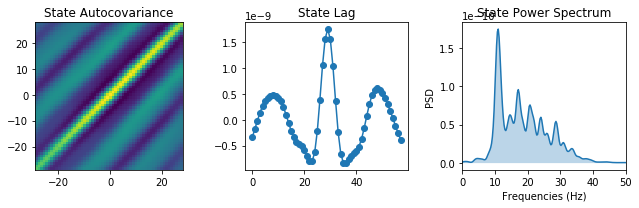

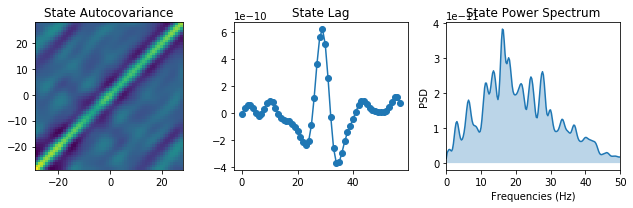

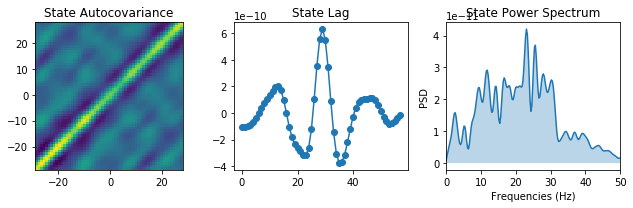

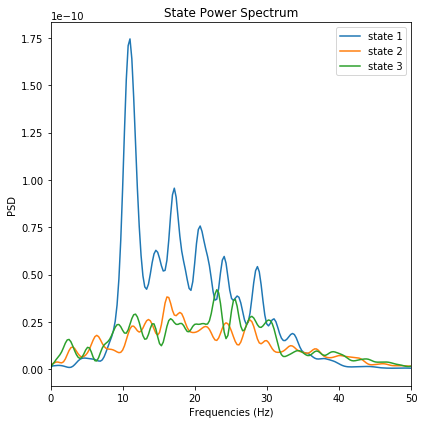

In [28]:
max_freq, max_power = show_states(subj, IC, trial, lags, n_states, covariance_type, model_type, tol, n_mix, save)

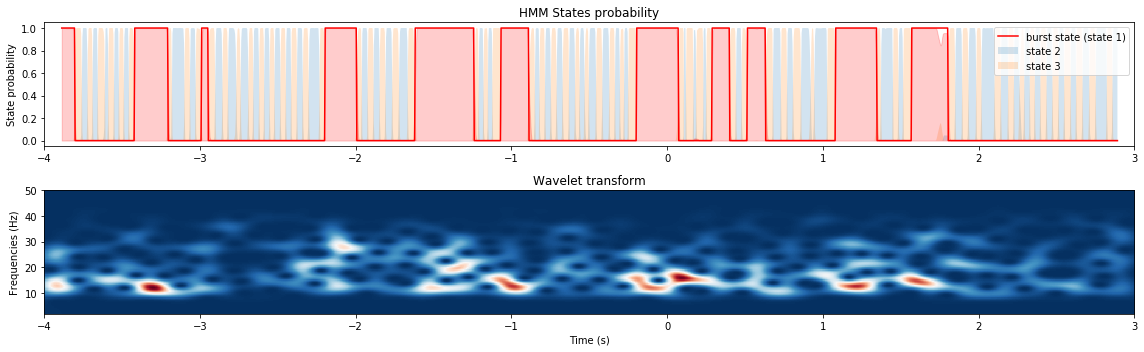

In [29]:
plot_hmm_over_tfr(subj, IC, trial, lags, n_states, covariance_type, model_type, tol, max_power, n_mix, save)